Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL10 Sequence-to-Sequence (Seq2Seq)

### Lab Description

This laboratory exercise introduces the **Sequence-to-Sequence (Seq2Seq)** architecture using Recurrent Neural Networks (RNNs) with Long Short-Term Memory (LSTM), a widely adopted technique in machine learning for sequence-based tasks. Seq2Seq is especially useful for applications such as machine translation, text summarization, and conversational modeling.

In this hands-on lab, students will construct a basic `English-to-Chinese` translation model using a small dataset of sentence pairs. The model will consist of an LSTM-based encoder and decoder. Through the training and inference process, students will gain practical understanding of how Seq2Seq models operate.

### What you can expect to learn

- Structural Understanding: Understand the basic architecture of a Seq2Seq model, including the roles of the encoder and decoder.
- Model Implementation: Learn how to implement Seq2Seq using LSTM layers in PyTorch.
- Training Technique: Explore the use of teacher forcing to improve training efficiency and convergence.
- Inference Practice: Gain experience in translating English sentences into Chinese using a trained Seq2Seq model.


### Import necessary libraries

In [ ]:
import os
import random
import re

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print("GPU Name:", torch.cuda.get_device_name(0))

cuda


### Required Dataset
We will use a small English-Chinese phrase dataset in the format:

```
Hello	你好
How are you?	你好嗎？
```

If you don’t have the dataset yet, you can create a small file called `eng-chn.txt` manually or download it from a trusted source.

In [ ]:
import hashlib


def _norm_en(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-z0-9’'.,!? \-]+", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()


def _norm_zh(s: str) -> str:
    s = s.strip()
    s = re.sub(r"[^\u4e00-\u9fffA-Za-z0-9，。！？、\.!?（）()：:；;“”\"\'《》【】\[\]\s\-]+", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()


def _valid_pair(en: str, zh: str, max_en_tokens=20, max_zh_chars=60, ratio_max=8.0) -> bool:
    if not en or not zh:
        return False
    en_len = len(en.split())
    zh_len = len(zh)
    if en_len == 0 or en_len > max_en_tokens:
        return False
    if zh_len > max_zh_chars:
        return False
    return not zh_len / max(1, en_len) > ratio_max


def read_data(filepath: str, num_sentences: int | None = None, char_level_zh: bool = False, deduplicate: bool = True):
    pairs, seen = [], set()
    with open(filepath, encoding="utf-8") as f:
        for i, line in enumerate(f, 1):
            if num_sentences and i > num_sentences:
                break
            if "\t" not in line:
                continue
            en, zh = line.rstrip("\n").split("\t", 1)
            en, zh = _norm_en(en), _norm_zh(zh)
            if not _valid_pair(en, zh):
                continue
            if char_level_zh:
                zh = " ".join(list(zh))
            if deduplicate:
                key = hashlib.md5(f"{en}\t{zh}".encode()).hexdigest()
                if key in seen:
                    continue
                seen.add(key)
            pairs.append([en, zh])
    print(f"[info] loaded {len(pairs)} clean pairs from {filepath}")
    return pairs


dataset_path = os.path.expanduser("./eng-chn.txt")
pairs = read_data(dataset_path, num_sentences=1000, char_level_zh=False, deduplicate=True)
print(random.choice(pairs))

[info] loaded 747 clean pairs from /home/aup/data/eng-chn.txt
['i am from please taipei', '我来自太平']


### Define Encoder and Decoder Models

The Seq2Seq model is composed of two main components: an **Encoder** and a **Decoder**, both implemented using LSTM layers.

- **EncoderRNN**: Takes in an input sequence (e.g., an English sentence), embeds each token, and passes the sequence through an LSTM. The final hidden and cell states summarize the input and are passed to the decoder.

- **DecoderRNN**: Starts from a special start-of-sequence token (`SOS_token`) and uses the encoded state to begin generating an output sequence (e.g., a Chinese sentence), one word at a time. It produces a probability distribution over the output vocabulary at each step.

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)  # (1, batch=1, hidden_size)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        h0 = torch.zeros(1, 1, self.hidden_size, device=device)
        c0 = torch.zeros(1, 1, self.hidden_size, device=device)
        return (h0, c0)


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)  # (1, batch=1, hidden_size)
        output, hidden = self.lstm(embedded, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        h0 = torch.zeros(1, 1, self.hidden_size, device=device)
        c0 = torch.zeros(1, 1, self.hidden_size, device=device)
        return (h0, c0)

### Build Vocabulary and Index Mapping

To train a Seq2Seq model, both the input and output languages must be converted into numerical representations. This is done by building a vocabulary and assigning a unique index to each word.

- We define two special tokens: `SOS_token` for start-of-sequence and `EOS_token` for end-of-sequence.
- The `Lang` class is used to:
  - Store mappings between words and indices.
  - Count word frequencies.
  - Maintain both `word2index` and `index2word` dictionaries.
- For each sentence pair in the dataset, we populate the English (`input_lang`) and Chinese (`output_lang`) vocabularies.

In [4]:
# Special tokens
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


input_lang = Lang("eng")
output_lang = Lang("chn")

for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])

### Tensor Preparation

Neural networks require input in the form of tensors. To convert natural language into tensors, we use the following helper functions:

- `indexesFromSentence(lang, sentence)`: Converts a sentence into a list of word indices based on the language's vocabulary.
- `tensorFromSentence(lang, sentence)`: Converts the list of indices into a PyTorch tensor and appends the `EOS_token` to indicate the end of the sequence.
- `tensorsFromPair(pair)`: Applies the conversion to both the input and output sentences in a sentence pair, returning the input and target tensors.

These functions prepare our sentence pairs for model training by converting them into a numerical format that the encoder and decoder can process.

In [5]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ") if word in lang.word2index]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return input_tensor, target_tensor

### Training Function

This function performs a single training step for the Seq2Seq model using a pair of input and target tensors. It follows the standard encoder-decoder training loop.

The encoder processes the input sequence and produces a hidden state that summarizes the input. The decoder then generates the target sequence one token at a time. During training, we use **teacher forcing**, where the correct target token is fed into the decoder as the next input with a certain probability (defined by `teacher_forcing_ratio`). This accelerates convergence and improves early-stage learning.

The function calculates the total loss using negative log-likelihood and updates both the encoder and decoder weights through backpropagation.

In [6]:
import json
import os
import shutil
import subprocess

import torch


def _to_mb(x):
    return None if x is None else round(x / (1024**2), 2)


def _which_rocm_smi():
    p = shutil.which("rocm-smi")
    if p:
        return p
    return "/opt/rocm/bin/rocm-smi" if os.path.exists("/opt/rocm/bin/rocm-smi") else None


_ROCM_SMI = _which_rocm_smi()


def rocm_query_util_and_vram():
    """Return {'util_percent': float|None, 'used_mib': float|None} from rocm-smi."""
    if not _ROCM_SMI:
        return {"util_percent": None, "used_mib": None}
    # Try JSON first
    try:
        out = subprocess.check_output([_ROCM_SMI, "--json"], text=True, stderr=subprocess.STDOUT, timeout=3)
        data = json.loads(out)
        card = data.get("card0") or data.get("card_0") or next(iter(data.values()))
        util = None
        used = None
        if isinstance(card, dict):
            util = card.get("GPU use (%)")
            if isinstance(util, str):
                util = float(re.sub(r"[^\d.]+", "", util))
            vram = card.get("VRAM") or card.get("vram") or {}
            used = vram.get("memory used (MiB)") or vram.get("used (MiB)")
            if isinstance(used, str):
                used = float(re.sub(r"[^\d.]+", "", used))
        return {
            "util_percent": (None if util is None else float(util)),
            "used_mib": (None if used is None else float(used)),
        }
    except Exception:
        pass
    # Fallback: human-readable
    try:
        out = subprocess.check_output(
            [_ROCM_SMI, "--showuse", "--showmemuse"], text=True, stderr=subprocess.STDOUT, timeout=3
        )
        m_util = re.search(r"GPU\s*use.*?:\s*([0-9]+)", out, re.I)
        m_used = re.search(r"(VRAM.*Used|memory\s*used).*?\(MiB\)\s*:\s*([0-9]+)", out, re.I)
        util = float(m_util.group(1)) if m_util else None
        used = float(m_used.group(2)) if m_used else None
        return {"util_percent": util, "used_mib": used}
    except Exception:
        return {"util_percent": None, "used_mib": None}


def get_vram_stats(device_id: int = 0):
    """Return current/reserved/peak VRAM usage in MB."""
    if not torch.cuda.is_available():
        return {"alloc": None, "resv": None, "peak": None}

    alloc = torch.cuda.memory_allocated(device_id) / 1024**2
    resv = torch.cuda.memory_reserved(device_id) / 1024**2
    peak = torch.cuda.max_memory_allocated(device_id) / 1024**2
    return {"alloc": round(alloc, 2), "resv": round(resv, 2), "peak": round(peak, 2)}

In [16]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    # --- Encoder ---
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei].to(device), encoder_hidden)

    # --- Decoder init ---
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = random.random() < teacher_forcing_ratio

    if use_teacher_forcing:
        # --- Teacher forcing ---
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di].to(device))
            decoder_input = target_tensor[di].unsqueeze(0).to(device)
    else:
        # --- Without teacher forcing ---
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach().view(1, 1).to(device)
            loss += criterion(decoder_output, target_tensor[di].to(device))
            if decoder_input.item() == EOS_token:
                break

    # --- Backprop ---
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

### Training

In [ ]:
import time

hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

learning_rate = 0.0005
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

num_epochs = 50
print_every = 1
plot_losses = []

for epoch in range(1, num_epochs + 1):
    t0 = time.time()
    total_loss = 0

    for pair in pairs:
        input_tensor, target_tensor = tensorsFromPair(pair)
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        total_loss += loss

    epoch_time = time.time() - t0
    avg_loss = total_loss / len(pairs)
    plot_losses.append(avg_loss)  # keep track of loss per epoch

    rsmi = rocm_query_util_and_vram()

    print(
        f"Epoch [{epoch}/{num_epochs}] "
        f"| Avg Loss: {avg_loss:.4f} "
        f"| Time: {epoch_time:.2f}s "
        f"| GPU util%={rsmi['util_percent']} "
    )

Epoch [1/50] | Avg Loss: 3.8254 | Time: 4.33s | VRAM alloc/resv/peak(MB)=45.94/216.0/169.6 | GPU util%=100.0 | rsmi_used(MiB)=None
Epoch [2/50] | Avg Loss: 3.9335 | Time: 4.74s | VRAM alloc/resv/peak(MB)=45.94/216.0/169.6 | GPU util%=100.0 | rsmi_used(MiB)=None
Epoch [3/50] | Avg Loss: 3.5622 | Time: 4.78s | VRAM alloc/resv/peak(MB)=45.94/216.0/169.6 | GPU util%=100.0 | rsmi_used(MiB)=None
Epoch [4/50] | Avg Loss: 3.1831 | Time: 4.45s | VRAM alloc/resv/peak(MB)=45.94/216.0/169.6 | GPU util%=100.0 | rsmi_used(MiB)=None
Epoch [5/50] | Avg Loss: 2.8420 | Time: 4.81s | VRAM alloc/resv/peak(MB)=45.94/216.0/169.6 | GPU util%=100.0 | rsmi_used(MiB)=None
Epoch [6/50] | Avg Loss: 2.4578 | Time: 4.86s | VRAM alloc/resv/peak(MB)=45.94/216.0/169.6 | GPU util%=100.0 | rsmi_used(MiB)=None
Epoch [7/50] | Avg Loss: 2.0641 | Time: 4.90s | VRAM alloc/resv/peak(MB)=45.94/216.0/169.6 | GPU util%=100.0 | rsmi_used(MiB)=None
Epoch [8/50] | Avg Loss: 1.6496 | Time: 4.54s | VRAM alloc/resv/peak(MB)=45.94/216.

### Evaluation Function

This function runs the trained Seq2Seq model in inference mode to translate an English input sentence into a Chinese output.

It first converts the input sentence into a tensor and passes it through the encoder to obtain the hidden state. This hidden state is then used by the decoder to generate the translation one word at a time.

At each decoding step, the decoder predicts a probability distribution over the output vocabulary. The word with the highest probability is selected (via `topk(1)`) and used as the input for the next step. This continues until the model predicts the `EOS_token` or reaches the maximum sequence length.

The function returns the translated output as a space-separated string of Chinese tokens.

In [18]:
def evaluate(encoder, decoder, sentence, max_length=20):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence).to(device)
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)

            token_id = topi.item()
            if token_id == EOS_token:
                break
            else:
                decoded_words.append(output_lang.index2word[token_id])

            decoder_input = topi.detach().view(1, 1).to(device)

        return " ".join(decoded_words)


# Test example
print(evaluate(encoder, decoder, "what is your name"))

你叫什么来着


### Results & Visualization

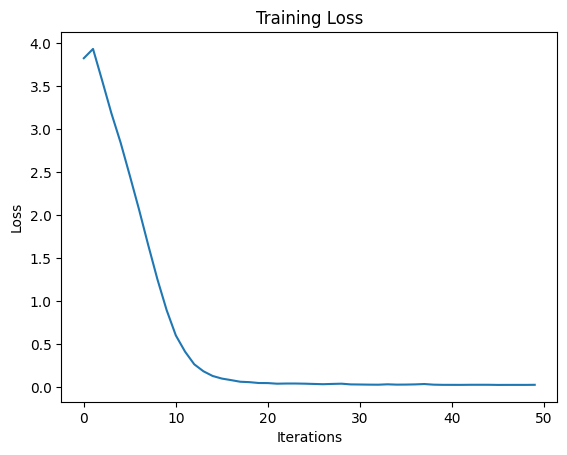

In [19]:
plt.plot(plot_losses)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()